In [72]:
import pandas as pd
# desactivate warnings
pd.options.mode.chained_assignment = None
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
tqdm.pandas()

from wordcloud import WordCloud
from collections import Counter
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/dabereabasse/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Get Data


In [4]:
# The dataset is downloaded from Hugging Face Datasets:

# @misc{wang2024huggingface,
#     author       = {Guoxuan Wang},
#     title        = {US Stock News With Price: A stock news and price dataset design for the alignment between financial news and the market.},
#     year         = {2024},
#     url          = {https://huggingface.co/datasets/oliverwang15/us_stock_news_with_price},
#     note         = {Available at Hugging Face.}
#   }

In [3]:
splits = {'train': 'data/train-00000-of-00001.parquet', 'test': 'data/test-00000-of-00001.parquet'}
train_data = pd.read_parquet("hf://datasets/oliverwang15/us_stock_news_with_price/" + splits["train"])
test_data = pd.read_parquet("hf://datasets/oliverwang15/us_stock_news_with_price/" + splits["test"])

/Users/dabereabasse/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/dabereabasse/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [5]:
# concatenate train and test data
data = pd.concat([train_data, test_data])

# sort by date
data = data.sort_values(by='date')

# keep only date, stock, title, content columns
data = data[['date', 'stock', 'title', 'content']]

print(data.shape)
data.head()

(105540, 4)


,date,stock,title,content
0,2009-12-14,AAPL,RadioShack (RSH +3.7%) should post outsized ga...,RadioShack (RSH\n+3.7%) should post outsized g...
9961,2009-12-14,CSCO,Dow leaders after one hour: AA +1.3%. MRK +1.2...,Dow leaders after one hour: AA\n+1.3%. MRK\n+1...
12908,2009-12-14,GOOG,AOL (NYSE:AOL) is in talks with Digital Sky Te...,AOL (NYSE:AOL) is in talks with Digital Sky Te...
12909,2009-12-14,GOOG,While Google (NASDAQ:GOOG) plans to sell the G...,While Google (NASDAQ:GOOG) plans to sell the G...
12911,2009-12-14,GOOG,Not only does Farhad Manjoo wonder if Google (...,Not only does Farhad Manjoo wonder if Google (...


In [7]:
# min date and max date
min_date, max_date = data['date'].min(), data['date'].max()
print(f"Min date: {min_date}")
print(f"Max date: {max_date}")
print()

# number of unique stocks
n_stocks = data['stock'].nunique()
print(f"Number of unique stocks: {n_stocks}")
print()

# number of news per stock
news_per_stock = data['stock'].value_counts()
news_per_stock.head(10)

Min date: 2009-12-14
Max date: 2023-10-23

Number of unique stocks: 100



stock
AAPL     8896
GOOG     6648
AMZN     6167
MSFT     5041
TSLA     4778
META     3808
GOOGL    3777
CMCSA    3042
INTC     3021
NFLX     2883
Name: count, dtype: int64

In [8]:
# Stocks that are present in the dataset
data['stock'].unique()

array(['AAPL', 'CSCO', 'GOOG', 'ON', 'AVGO', 'ADBE', 'MSFT', 'PAYX',
       'AMD', 'INTC', 'HON', 'AMZN', 'NVDA', 'CTAS', 'MU', 'CMCSA',
       'AMGN', 'EA', 'PEP', 'MRVL', 'INTU', 'ODFL', 'QCOM', 'BIIB',
       'NFLX', 'AZN', 'ROST', 'TXN', 'COST', 'CSX', 'FAST', 'SBUX',
       'EBAY', 'ASML', 'ISRG', 'EXC', 'MAR', 'SIRI', 'GILD', 'BKR',
       'FTNT', 'LRCX', 'KLAC', 'XEL', 'AEP', 'ALGN', 'PCAR', 'ADP',
       'CDNS', 'VRTX', 'ILMN', 'MCHP', 'CTSH', 'ORLY', 'AMAT', 'ADI',
       'SNPS', 'ADSK', 'MELI', 'DLTR', 'LULU', 'REGN', 'VRSK', 'DXCM',
       'CHTR', 'NXPI', 'TSLA', 'CPRT', 'CSGP', 'ANSS', 'IDXX', 'MNST',
       'MDLZ', 'TMUS', 'META', 'ENPH', 'PANW', 'WDAY', 'FANG', 'GOOGL',
       'JD', 'WBA', 'KHC', 'PYPL', 'TEAM', 'TTD', 'BKNG', 'ZS', 'KDP',
       'PDD', 'MRNA', 'ZM', 'CRWD', 'DDOG', 'LCID', 'ABNB', 'WBD', 'GFS',
       'CEG', 'GEHC'], dtype=object)

## AAPL stock news analysis


In [12]:
# keep only AAPL stock news
# aapl_data = data[data["stock"] == "AAPL"]
aapl_data = pd.read_csv('../data/AAPL/news.csv')
aapl_data['date'] = pd.to_datetime(aapl_data['date'])
aapl_data = aapl_data.sort_values(by='date')
aapl_data = aapl_data.reset_index(drop=True)

print(aapl_data.shape)
aapl_data.head()

(8896, 4)


,date,stock,title,content
0,2009-12-14,AAPL,RadioShack (RSH +3.7%) should post outsized ga...,RadioShack (RSH\n+3.7%) should post outsized g...
1,2009-12-18,AAPL,AT&T (NYSE:T) has responded to criticism of it...,AT&T (NYSE:T) has responded to criticism of it...
2,2009-12-21,AAPL,Yelp reportedly shuns an all-but-signed deal t...,Yelp reportedly shuns an all-but-signed deal t...
3,2009-12-22,AAPL,Sources say CBS (NYSE:CBS) and Disney (NYSE:DI...,Sources say CBS (NYSE:CBS) and Disney (NYSE:DI...
4,2009-12-25,AAPL,Top two spots on Amazon.com's (NASDAQ:AMZN) Mo...,Top two spots on Amazon.com's (NASDAQ:AMZN) Mo...


### news count by date


In [13]:
## min and max date
min_date, max_date = aapl_data['date'].min(), aapl_data['date'].max()
print(f"Min date: {min_date}")
print(f"Max date: {max_date}")

Min date: 2009-12-14 00:00:00
Max date: 2023-10-16 00:00:00


In [14]:
## news count by date
date_range = pd.date_range(start=min_date, end=max_date)
news_count = aapl_data['date'].value_counts().reindex(date_range, fill_value=0)
news_count.head()

2009-12-14    1
2009-12-15    0
2009-12-16    0
2009-12-17    0
2009-12-18    1
Freq: D, Name: count, dtype: int64

In [15]:
## statistics on news per day
news_count.describe()

count    5055.000000
mean        1.759842
std         2.060158
min         0.000000
25%         0.000000
50%         1.000000
75%         3.000000
max        21.000000
Name: count, dtype: float64

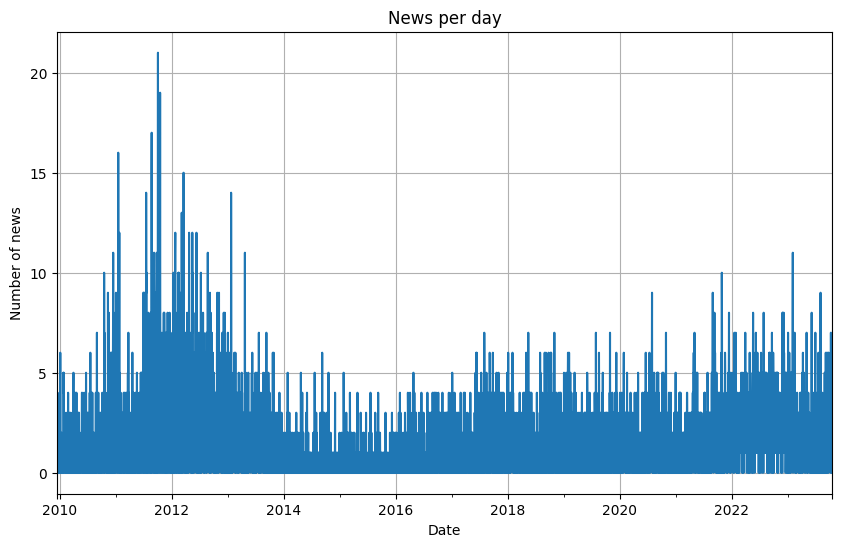

In [16]:
# plot news per day

plt.figure(figsize=(10, 6))
news_count.plot()
plt.title('News per day')
plt.xlabel('Date')
plt.ylabel('Number of news')
plt.grid()
plt.show()

### News checking


In [59]:
def preprocess_text(text):
    text = text.lower() #Convert text to lower-case
    text = re.sub(r'[^\w\s]', '', text) #Remove punctuation
    text = re.sub(r'@[A-Za-z0–9]+', '', text) #Remove @mentions replace with blank
    text = re.sub(r'#', '', text) #Remove the '#' symbol, replace with blank
    text = re.sub(r'RT[\s]+', '', text) #Removing RT, replace with blank
    text = re.sub(r'https?:\/\/\S+', '', text) #Remove the hyperlinks
    text = re.sub(r':', '', text) # Remove : symbol
    text = re.sub(r'‚Ä¶', '', text) # Remove ‚Ä¶ symbol
    text = re.sub(r'[^\x00-\x7F]+', '', text) # Remove non-ASCII characters
    words = text.split()
    words = [word for word in words if word not in set(stopwords.words('english'))]
    return ' '.join(words)

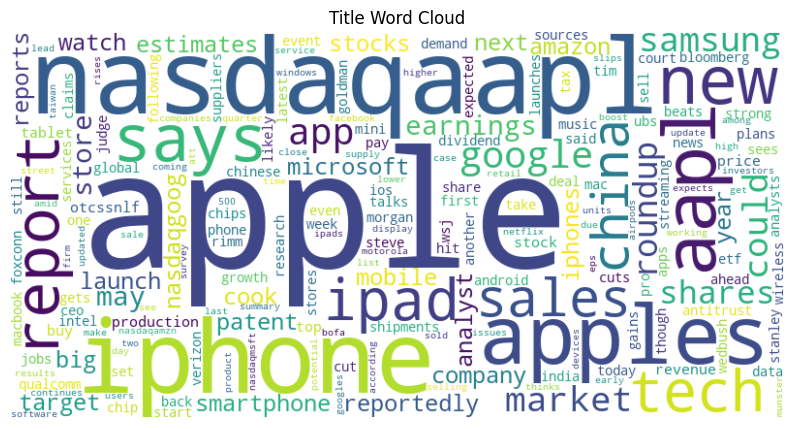

In [60]:
# word cloud
def plot_word_cloud(text, title):
    wc = WordCloud(width=800, height=400, max_words=200, background_color='white').generate_from_frequencies(text)
    plt.figure(figsize=(10, 6))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

# word cloud for title
title_text = ' '.join(aapl_data['title'])
title_text = preprocess_text(title_text)
title_text = title_text.split()
title_text = [word for word in title_text if len(word) > 2]
title_text = ' '.join(title_text)
title_text = Counter(title_text.split())
plot_word_cloud(title_text, 'Title Word Cloud')

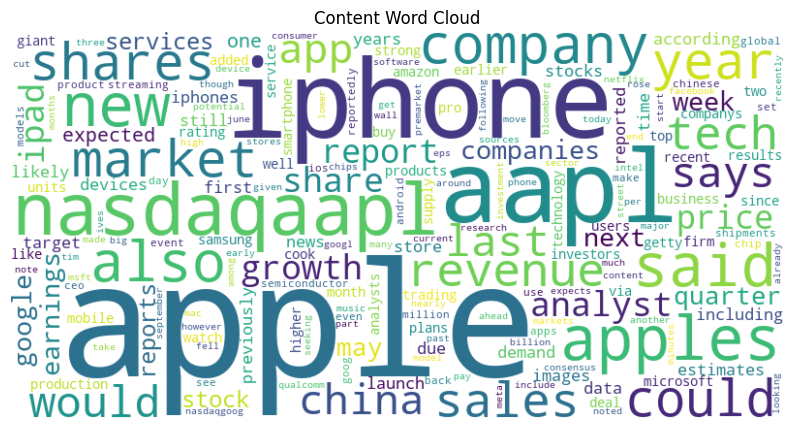

In [61]:
# word cloud for content
content_text = ' '.join(aapl_data['content'])
content_text = preprocess_text(content_text)
content_text = content_text.split()
content_text = [word for word in content_text if len(word) > 2]
content_text = ' '.join(content_text)
content_text = Counter(content_text.split())
plot_word_cloud(content_text, 'Content Word Cloud')

### Sentiment


In [21]:
# sentiment analysis
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")

In [36]:
# model.config

In [50]:
def calculate_sentiment_score(text):
    max_tokens = tokenizer.model_max_length
    tokens = tokenizer.tokenize(text)
    
    # Diviser le texte en morceaux pour respecter la limite de tokens
    chunks = [" ".join(tokens[i:i + max_tokens]) for i in range(0, len(tokens), max_tokens)]
    
    scores = {"positive": 0, "negative": 0, "neutral": 0}
    total_chunks = len(chunks)
    
    for chunk in chunks:
        inputs = tokenizer(chunk, return_tensors="pt", truncation=True, max_length=max_tokens)
        outputs = model(**inputs)
        probabilities = torch.nn.functional.softmax(outputs.logits, dim=-1)

        # Ajouter les scores du chunk
        scores["positive"] += probabilities[0][0].item()
        scores["negative"] += probabilities[0][1].item()
        scores["neutral"] += probabilities[0][2].item()
    
    if total_chunks == 0:
        return 0
        
    # Normaliser les scores par le nombre de morceaux
    for key in scores:
        scores[key] /= total_chunks

    return scores

In [62]:
# print 5 random posts with sentiment analysis
seed = 42
N = 5
posts_sample = aapl_data.sample(n=N, random_state=seed)

for i, row in posts_sample.iterrows():
    text = preprocess_text(row['title'] + ' ' + row['content'])
    sentiment = calculate_sentiment_score(text)
    print('#'*100)
    print(f"Title: {row['title']}")
    print(f"Content: {row['content']}")
    print()
    print(f"Sentiment: {sentiment}")
    print()

####################################################################################################
Title: 'Fortnite' is back on iOS - thanks to Nvidia's loophole
Content: Christian Petersen/Getty Images News


Nearly 18 months after Apple (NASDAQ:AAPL) removed Epic Game's popular "Fortnite" from the App Store, a decision that led to an antitrust lawsuit and appeals, "Fortnite" is back on iOS, thanks to a workaround from Nvidia (NASDAQ:NVDA).

Nvidia's GeForce Now service opened up a closed beta on Thursday to test the streaming version of the game, with Nvidia writing in a November 2020 blog post that "Fortnite" would come to iOS on Safari "soon," but did not give a date at the time.
To be clear, "Fortnite," which has helped Epic Games generate more than $9 billion in revenue, is not on the App Store, where it was removed in August 2020. Instead, it can be played on iOS via the Safari web browser, where other streaming services, such as Microsoft's (NASDAQ:MSFT) xCloud, Stadia and th

In [63]:
aapl_data.head()

,date,stock,title,content
0,2009-12-14,AAPL,RadioShack (RSH +3.7%) should post outsized ga...,RadioShack (RSH\n+3.7%) should post outsized g...
1,2009-12-18,AAPL,AT&T (NYSE:T) has responded to criticism of it...,AT&T (NYSE:T) has responded to criticism of it...
2,2009-12-21,AAPL,Yelp reportedly shuns an all-but-signed deal t...,Yelp reportedly shuns an all-but-signed deal t...
3,2009-12-22,AAPL,Sources say CBS (NYSE:CBS) and Disney (NYSE:DI...,Sources say CBS (NYSE:CBS) and Disney (NYSE:DI...
4,2009-12-25,AAPL,Top two spots on Amazon.com's (NASDAQ:AMZN) Mo...,Top two spots on Amazon.com's (NASDAQ:AMZN) Mo...


In [78]:
# calculate sentiment score for each rows
def add_sentiment_scores(row):
    preprocessed_text = preprocess_text(row['content'])
    sentiment_scores = calculate_sentiment_score(preprocessed_text)
    return pd.Series(sentiment_scores)

aapl_data[['positive', 'neutral', 'negative']] = aapl_data.progress_apply(add_sentiment_scores, axis=1)

100%|██████████| 8896/8896 [15:22<00:00,  9.64it/s]


In [79]:
aapl_data.head()

,date,stock,title,content,positive,neutral,negative
0,2009-12-14,AAPL,RadioShack (RSH +3.7%) should post outsized ga...,RadioShack (RSH\n+3.7%) should post outsized g...,0.293675,0.012213,0.694112
1,2009-12-18,AAPL,AT&T (NYSE:T) has responded to criticism of it...,AT&T (NYSE:T) has responded to criticism of it...,0.074762,0.335630,0.589608
2,2009-12-21,AAPL,Yelp reportedly shuns an all-but-signed deal t...,Yelp reportedly shuns an all-but-signed deal t...,0.066094,0.015236,0.918670
3,2009-12-22,AAPL,Sources say CBS (NYSE:CBS) and Disney (NYSE:DI...,Sources say CBS (NYSE:CBS) and Disney (NYSE:DI...,0.145811,0.009512,0.844678
4,2009-12-25,AAPL,Top two spots on Amazon.com's (NASDAQ:AMZN) Mo...,Top two spots on Amazon.com's (NASDAQ:AMZN) Mo...,0.047836,0.025446,0.926718


In [80]:
aapl_data.to_csv('../data/AAPL/news_sentiment.csv', index=False)

### Topic Modeling


### Comptage de Mots Clés et d’Entités Nommées
